In [1]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import time

from common import eigval_hessian, plot_data
from GradientDescent import GM
from RandomBCGD import rand_BCGD
from GaussSouthwellBCGD import GS_BCGD

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
config = {
    'Noofsamples': 10000,
    'Noofcenters': 2,
    'Nooffeatures': 2,
    'testsize': 0.97,
    'learningrate': 0.005,
    'maxiterations': 1000,
    'epsilon': 0.01,
    'epsilon2': 0.001,
    'randomseed': 16,
}

# Generated Dataset

In [3]:
def prepare_data(config):
    noofsamples = config['Noofsamples']
    noofcenters = config['Noofcenters']
    nooffeatures = config['Nooffeatures']
    testsize = config['testsize']
    lr = config['learningrate']
    max_iter = config['maxiterations']
    eps = config['epsilon']
    random_seed = config['randomseed']


    X, y = make_blobs(n_samples=noofsamples, centers=noofcenters, n_features=nooffeatures, random_state=random_seed)

    y[y == 0] = -1

    # first we shuffle and build the similarity matrix in order to separate later without shuffling and keep the form of the W matrix
    X, y = shuffle(X, y, random_state=random_seed)
    # W = 1 / (pairwise_distances(X) + 0.0001)
    W  = np.exp(-(euclidean_distances(X, squared=True)) * 0.5)
    X_l, X_u, y_l, y_u , W_l, W_u = train_test_split(X, y, W, test_size = testsize, shuffle=False)

    # delete the first 300 columns from the similarity matrix as we don't need them 
    n = len(y_l)
    W_l = W_l[:,n:]
    W_u = W_u[:,n:]

    return X,y,X_l,X_u,y_l,y_u,W_l,W_u,lr,max_iter,eps,random_seed

In [5]:
X,y,X_l,X_u,y_l,y_u,W_l,W_u,lr,max_iter,eps,random_seed = prepare_data(config)

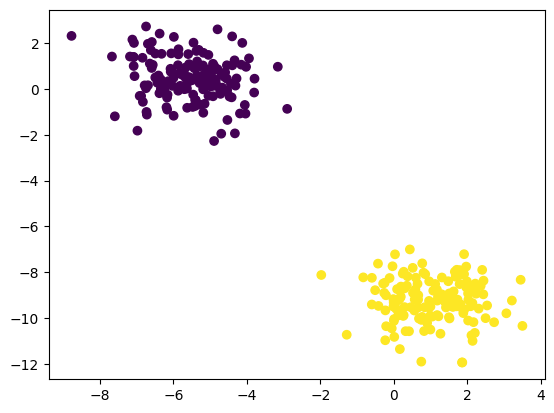

In [6]:
plot_data(X_l,y_l)

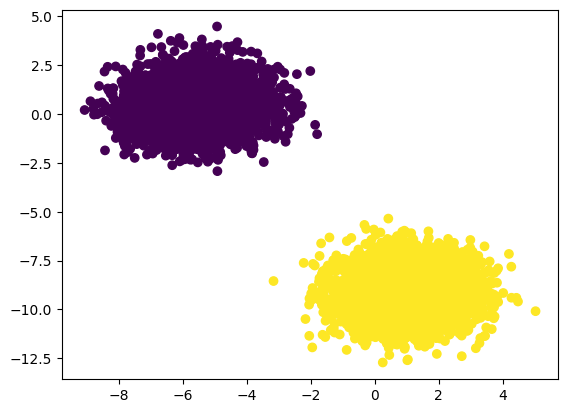

In [7]:
plot_data(X_u,y_u)

In [8]:
L = eigval_hessian(W_l, W_u)
stepsize = 1/L
L, stepsize

(5010.902010253228, 0.00019956486835180892)

In [10]:
n = len(W_u)
hes = W_u * (-2)
diag_values = (W_l.sum(axis=0) + W_u.sum(axis=0)) * 2
np.fill_diagonal(hes, diag_values)
L_i = np.linalg.norm(hes, axis=1)

In [11]:
%%time
y_pred_GM, grad_GM, time_stat_GM, of_GM = GM(y_l, W_l, W_u, 0.0003989705555037583, max_iter, eps, calc_of=False)

Initial loss: 500457.69665614463
Iteration 1: gradient norm 12167.674319815413
Iteration 2: gradient norm 10047.804214485388
Iteration 3: gradient norm 9018.967602313855
Iteration 4: gradient norm 8208.851838558508
Iteration 5: gradient norm 7508.214792861712
Iteration 6: gradient norm 6883.161430542023
Iteration 7: gradient norm 6318.089046039029
Iteration 8: gradient norm 5803.839076700032
Iteration 9: gradient norm 5334.108241827201
Iteration 10: gradient norm 4904.087574786842
Iteration 11: gradient norm 4509.860240031094
Iteration 12: gradient norm 4148.10200505645
Iteration 13: gradient norm 3815.9171759822866
Iteration 14: gradient norm 3510.7408472425614
Iteration 15: gradient norm 3230.276105136567
Iteration 16: gradient norm 2972.450878778864
Iteration 17: gradient norm 2735.3864971356143
Iteration 18: gradient norm 2517.3736089781673
Iteration 19: gradient norm 2316.852976069016
Iteration 20: gradient norm 2132.3996495231877
Iteration 21: gradient norm 1962.7096008054255
Ite

In [12]:
y_pred_GMc, grad_GMc, time_stat_GMc, of_GMc = GM(y_l, W_l, W_u, stepsize, max_iter, eps, calc_of=False)

Initial loss: 500457.69665614463
Iteration 1: gradient norm 12167.674319815413
Iteration 2: gradient norm 10829.002424547467
Iteration 3: gradient norm 10084.251156979868
Iteration 4: gradient norm 9521.91557720632
Iteration 5: gradient norm 9046.582472188442
Iteration 6: gradient norm 8623.116807802786
Iteration 7: gradient norm 8235.364031536828
Iteration 8: gradient norm 7874.745551950511
Iteration 9: gradient norm 7536.190531363788
Iteration 10: gradient norm 7216.433945362414
Iteration 11: gradient norm 6913.219631481935
Iteration 12: gradient norm 6624.893625880604
Iteration 13: gradient norm 6350.181914736899
Iteration 14: gradient norm 6088.061914527456
Iteration 15: gradient norm 5837.684539014493
Iteration 16: gradient norm 5598.324983167014
Iteration 17: gradient norm 5369.350527130689
Iteration 18: gradient norm 5150.198809906676
Iteration 19: gradient norm 4940.362755300896
Iteration 20: gradient norm 4739.379846494644
Iteration 21: gradient norm 4546.82431580902
Iteration

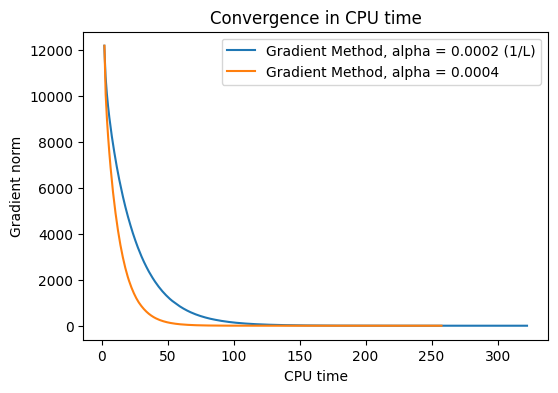

In [13]:
plt.figure(figsize=(6,4))
plt.plot(time_stat_GMc[1:], grad_GMc, label = "Gradient Method, alpha = 0.0002 (1/L)")
plt.plot(time_stat_GM[1:], grad_GM, label = "Gradient Method, alpha = 0.0004")
plt.title("Convergence in CPU time")
plt.xlabel("CPU time")
plt.ylabel("Gradient norm")
plt.legend();

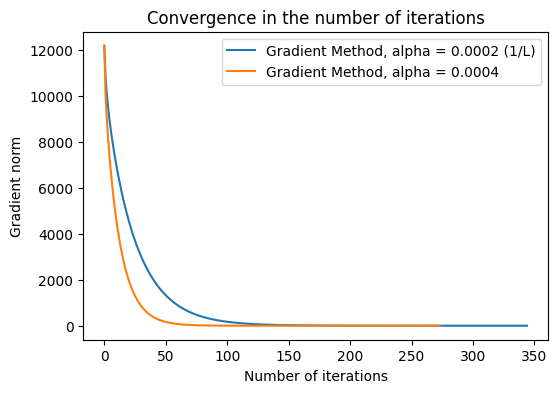

In [14]:
plt.figure(figsize=(6,4))
plt.plot(grad_GMc, label = "Gradient Method, alpha = 0.0002 (1/L)")
plt.plot(grad_GM, label = "Gradient Method, alpha = 0.0004")
plt.title("Convergence in the number of iterations")
plt.xlabel("Number of iterations")
plt.ylabel("Gradient norm")
plt.legend();

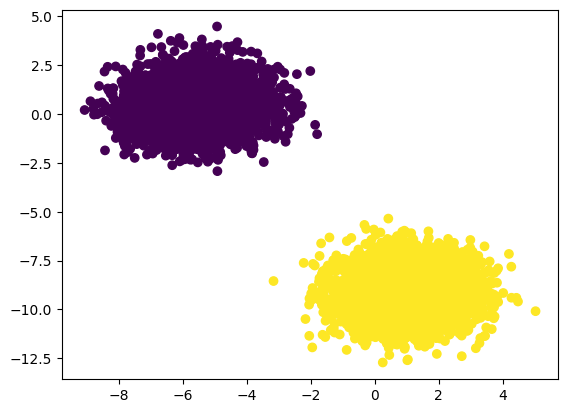

In [15]:
plot_data(X_u, y_pred_GM)

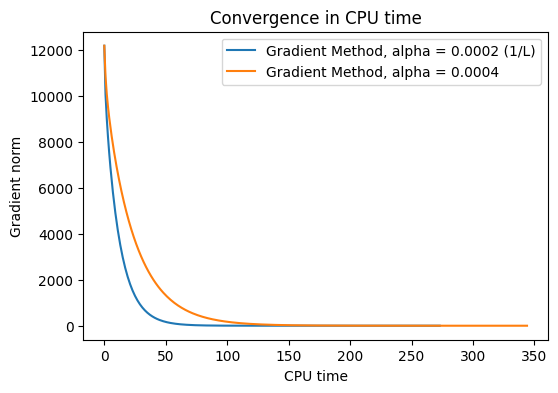

In [16]:
plt.figure(figsize=(6,4))
plt.plot(grad_GM, label = "Gradient Method, alpha = 0.0002 (1/L)")
plt.plot(grad_GMc, label = "Gradient Method, alpha = 0.0004")
plt.title("Convergence in CPU time")
plt.xlabel("CPU time")
plt.ylabel("Gradient norm")
plt.legend();

In [17]:
%%time
y_pred_RB, grad_RB, time_stat_RB, of_RB = rand_BCGD(y_l, W_l, W_u, L_i, max_iter, eps, random_seed=random_seed)

Initial loss: 500457.69665614463
Cycle 1: gradient norm 16173.548502945267
Cycle 2: gradient norm 18875.095568706714
Cycle 3: gradient norm 20721.7664467111
Cycle 4: gradient norm 19630.38500631483
Cycle 5: gradient norm 18533.626882957567
Cycle 6: gradient norm 17748.067895958215
Cycle 7: gradient norm 16492.595699595364
Cycle 8: gradient norm 15242.98947545682
Cycle 9: gradient norm 14932.737420348649
Cycle 10: gradient norm 13971.589563221554
Cycle 11: gradient norm 13035.10756572227
Cycle 12: gradient norm 12218.783513188084
Cycle 13: gradient norm 11640.888285192637
Cycle 14: gradient norm 10272.626327392381
Cycle 15: gradient norm 10207.432207808022
Cycle 16: gradient norm 9353.155884474829
Cycle 17: gradient norm 8935.23747107865
Cycle 18: gradient norm 8417.629758826577
Cycle 19: gradient norm 7682.077995296579
Cycle 20: gradient norm 7215.695364796977
Cycle 21: gradient norm 7179.522090556884
Cycle 22: gradient norm 6591.244455115911
Cycle 23: gradient norm 6112.38427929968
Cy

In [18]:
%%time
y_pred_RBc, grad_RBc, time_stat_RBc, of_RBc = rand_BCGD(y_l, W_l, W_u, L_i, max_iter, eps, random_seed=random_seed)

Initial loss: 500457.69665614463
Cycle 1: gradient norm 16173.548502945267
Cycle 2: gradient norm 18875.095568706714
Cycle 3: gradient norm 20721.7664467111
Cycle 4: gradient norm 19630.38500631483
Cycle 5: gradient norm 18533.626882957567
Cycle 6: gradient norm 17748.067895958215
Cycle 7: gradient norm 16492.595699595364
Cycle 8: gradient norm 15242.98947545682
Cycle 9: gradient norm 14932.737420348649
Cycle 10: gradient norm 13971.589563221554
Cycle 11: gradient norm 13035.10756572227
Cycle 12: gradient norm 12218.783513188084
Cycle 13: gradient norm 11640.888285192637
Cycle 14: gradient norm 10272.626327392381
Cycle 15: gradient norm 10207.432207808022
Cycle 16: gradient norm 9353.155884474829
Cycle 17: gradient norm 8935.23747107865
Cycle 18: gradient norm 8417.629758826577
Cycle 19: gradient norm 7682.077995296579
Cycle 20: gradient norm 7215.695364796977
Cycle 21: gradient norm 7179.522090556884
Cycle 22: gradient norm 6591.244455115911
Cycle 23: gradient norm 6112.38427929968
Cy

In [19]:
%%time
y_pred_RBn, grad_RBn, time_stat_RBn, of_RBn = rand_BCGD(y_l, W_l, W_u, L_i, max_iter, eps, nesterov_sampling=True, random_seed=random_seed)

Initial loss: 500457.69665614463
Cycle 1: gradient norm 18991.03589790139
Cycle 2: gradient norm 21097.818445559235
Cycle 3: gradient norm 19842.29314998789
Cycle 4: gradient norm 18214.314784987553
Cycle 5: gradient norm 17165.682030467317
Cycle 6: gradient norm 15297.206796633374
Cycle 7: gradient norm 14622.549186567538
Cycle 8: gradient norm 13416.601572059832
Cycle 9: gradient norm 13053.274784014
Cycle 10: gradient norm 12101.792825330267
Cycle 11: gradient norm 11224.126774300597
Cycle 12: gradient norm 10661.171015294223
Cycle 13: gradient norm 9729.968816058998
Cycle 14: gradient norm 9181.677506727217
Cycle 15: gradient norm 8753.469176141753
Cycle 16: gradient norm 8178.425616862497
Cycle 17: gradient norm 7445.431759289802
Cycle 18: gradient norm 7069.981810048204
Cycle 19: gradient norm 6838.219500207431
Cycle 20: gradient norm 6208.364582961811
Cycle 21: gradient norm 6033.315234853744
Cycle 22: gradient norm 5545.320355783647
Cycle 23: gradient norm 5281.584003138017
Cyc

In [20]:
%%time
y_pred_RB2, grad_RB2, time_stat_RB2, of_RB2 = rand_BCGD(y_l, W_l, W_u, L_i, max_iter, eps, alpha_min=stepsize, random_seed=random_seed)

Initial loss: 500457.69665614463
Cycle 1: gradient norm 16173.548502945267
Cycle 2: gradient norm 18875.095568706714
Cycle 3: gradient norm 20721.7664467111
Cycle 4: gradient norm 19630.38500631483
Cycle 5: gradient norm 18533.626882957567
Cycle 6: gradient norm 17748.067895958215
Cycle 7: gradient norm 16492.595699595364
Cycle 8: gradient norm 15242.98947545682
Cycle 9: gradient norm 14932.737420348649
Cycle 10: gradient norm 13971.589563221554
Cycle 11: gradient norm 13035.10756572227
Cycle 12: gradient norm 12218.783513188084
Cycle 13: gradient norm 11640.888285192637
Cycle 14: gradient norm 10272.626327392381
Cycle 15: gradient norm 10207.432207808022
Cycle 16: gradient norm 9353.155884474829
Cycle 17: gradient norm 8935.23747107865
Cycle 18: gradient norm 8417.629758826577
Cycle 19: gradient norm 7682.077995296579
Cycle 20: gradient norm 7215.695364796977
Cycle 21: gradient norm 7179.522090556884
Cycle 22: gradient norm 6591.244455115911
Cycle 23: gradient norm 6112.38427929968
Cy

In [21]:
%%time
y_pred_RB3, grad_RB3, time_stat_RB3, of_RB3 = rand_BCGD(y_l, W_l, W_u, np.repeat(L, len(W_u)), max_iter, eps, random_seed=random_seed)

Initial loss: 500457.69665614463
Cycle 1: gradient norm 14355.673218461272
Cycle 2: gradient norm 15349.932053390847
Cycle 3: gradient norm 16157.932518529025
Cycle 4: gradient norm 15181.798458841196
Cycle 5: gradient norm 14333.190153951722
Cycle 6: gradient norm 13631.13190325815
Cycle 7: gradient norm 12880.162645236464
Cycle 8: gradient norm 12218.382626446379
Cycle 9: gradient norm 11885.964397835434
Cycle 10: gradient norm 11339.018561901732
Cycle 11: gradient norm 10817.450049951214
Cycle 12: gradient norm 10198.117764445005
Cycle 13: gradient norm 10056.587663563017
Cycle 14: gradient norm 9144.517416863018
Cycle 15: gradient norm 9003.10500427352
Cycle 16: gradient norm 8581.342547995975
Cycle 17: gradient norm 8343.350958412988
Cycle 18: gradient norm 8015.033431032933
Cycle 19: gradient norm 7457.666659023077
Cycle 20: gradient norm 7218.708145741868
Cycle 21: gradient norm 7229.2162182281945
Cycle 22: gradient norm 6750.347934015912
Cycle 23: gradient norm 6421.76608458093

In [22]:
%%time
y_pred_RB4, grad_RB4, time_stat_RB4, of_RB4 = rand_BCGD(y_l, W_l, W_u, np.repeat(3333, len(W_u)), max_iter, eps, random_seed=random_seed)

Initial loss: 500457.69665614463
Cycle 1: gradient norm 17634.4676717293
Cycle 2: gradient norm 21124.806329455663
Cycle 3: gradient norm 22715.667171690504
Cycle 4: gradient norm 21123.202343814322
Cycle 5: gradient norm 19553.97984618474
Cycle 6: gradient norm 18224.278604109808
Cycle 7: gradient norm 16797.904510270328
Cycle 8: gradient norm 15170.699839806633
Cycle 9: gradient norm 14939.482143720954
Cycle 10: gradient norm 14012.380806678739
Cycle 11: gradient norm 12875.865266279665
Cycle 12: gradient norm 11969.54646051081
Cycle 13: gradient norm 11461.92978328141
Cycle 14: gradient norm 10082.16110293846
Cycle 15: gradient norm 10023.475573144347
Cycle 16: gradient norm 9151.320678295882
Cycle 17: gradient norm 8814.658076236736
Cycle 18: gradient norm 8179.945320950144
Cycle 19: gradient norm 7561.418858969068
Cycle 20: gradient norm 7032.544210108897
Cycle 21: gradient norm 7058.754173626024
Cycle 22: gradient norm 6498.659774281588
Cycle 23: gradient norm 6038.323773338044
C

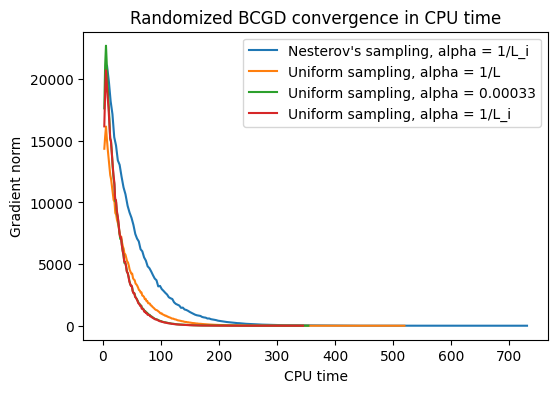

In [23]:
plt.figure(figsize=(6,4))
plt.plot(time_stat_RBn[1:], grad_RBn, label = "Nesterov's sampling, alpha = 1/L_i")
plt.plot(time_stat_RB3[1:], grad_RB3, label = "Uniform sampling, alpha = 1/L")
plt.plot(time_stat_RB4[1:], grad_RB4, label = "Uniform sampling, alpha = 0.00033")
plt.plot(time_stat_RBc[1:], grad_RBc, label = "Uniform sampling, alpha = 1/L_i")
plt.title("Randomized BCGD convergence in CPU time")
plt.xlabel("CPU time")
plt.ylabel("Gradient norm")
plt.legend();

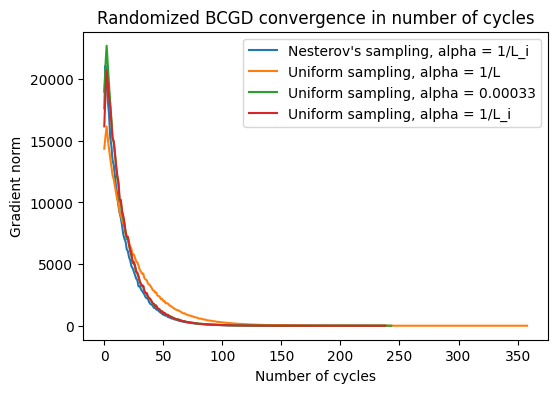

In [24]:
plt.figure(figsize=(6,4))
plt.plot(grad_RBn, label = "Nesterov's sampling, alpha = 1/L_i")
plt.plot(grad_RB3, label = "Uniform sampling, alpha = 1/L")
plt.plot(grad_RB4, label = "Uniform sampling, alpha = 0.00033")
plt.plot(grad_RBc, label = "Uniform sampling, alpha = 1/L_i")
plt.title("Randomized BCGD convergence in number of cycles")
plt.xlabel("Number of cycles")
plt.ylabel("Gradient norm")
plt.legend();

In [25]:
%%time
y_pred_GS, grad_GS, time_stat_GS, of_GS = GS_BCGD(y_l, W_l, W_u, L_i, max_iter, eps)

Initial loss: 500457.69665614463
Cycle 1: gradient norm 34792.10003630484
Cycle 2: gradient norm 27388.487456839972
Cycle 3: gradient norm 39450.83825656305
Cycle 4: gradient norm 29842.0401548943
Cycle 5: gradient norm 23029.681909360934
Cycle 6: gradient norm 20579.80405627614
Cycle 7: gradient norm 18034.340062537744
Cycle 8: gradient norm 16015.940663990365
Cycle 9: gradient norm 14156.186655104024
Cycle 10: gradient norm 12433.370523418283
Cycle 11: gradient norm 11006.640927168663
Cycle 12: gradient norm 9606.814640174625
Cycle 13: gradient norm 8557.409721356793
Cycle 14: gradient norm 7491.035293587709
Cycle 15: gradient norm 6624.935785699597
Cycle 16: gradient norm 5820.778660181605
Cycle 17: gradient norm 5148.044029394054
Cycle 18: gradient norm 4543.115304291457
Cycle 19: gradient norm 4066.8293507940625
Cycle 20: gradient norm 3521.0428481139893
Cycle 21: gradient norm 3118.2353793600832
Cycle 22: gradient norm 2732.7895107513405
Cycle 23: gradient norm 2448.1029419075803

In [26]:
%%time
y_pred_GS2, grad_GS2, time_stat_GS2, of_GS2 = GS_BCGD(y_l, W_l, W_u, L_i, max_iter, eps, alpha_min=0.0003989705555037583)

Initial loss: 500457.69665614463
Cycle 1: gradient norm 74145.01951232766
Cycle 2: gradient norm 38238.62439663482
Cycle 3: gradient norm 108185.14094074837
Cycle 4: gradient norm 66878.79281839574
Cycle 5: gradient norm 30189.687450527435
Cycle 6: gradient norm 20390.453823146847
Cycle 7: gradient norm 15441.939161403116
Cycle 8: gradient norm 11030.87664111359
Cycle 9: gradient norm 7964.57129662234
Cycle 10: gradient norm 5904.921478428663
Cycle 11: gradient norm 4293.1547150001325
Cycle 12: gradient norm 2953.9883332264963
Cycle 13: gradient norm 2147.1397182415726
Cycle 14: gradient norm 1556.044601181339
Cycle 15: gradient norm 1157.6068131999064
Cycle 16: gradient norm 849.126862313186
Cycle 17: gradient norm 653.0738475478332
Cycle 18: gradient norm 462.4276751915454
Cycle 19: gradient norm 304.953978592922
Cycle 20: gradient norm 223.41679110617832
Cycle 21: gradient norm 163.20285145664542
Cycle 22: gradient norm 118.62422956276673
Cycle 23: gradient norm 87.29208325752809
Cy

In [27]:
%%time
y_pred_GS3, grad_GS3, time_stat_GS3, of_GS3 = GS_BCGD(y_l, W_l, W_u, np.repeat(1/0.0003989705555037583, len(W_u)), max_iter, eps)

Initial loss: 500457.69665614463
Cycle 1: gradient norm 63625.740437231565
Cycle 2: gradient norm 32024.441242908233
Cycle 3: gradient norm 94871.14643557189
Cycle 4: gradient norm 40818.83242244557
Cycle 5: gradient norm 23060.25891104539
Cycle 6: gradient norm 18133.437191942514
Cycle 7: gradient norm 13781.253985555682
Cycle 8: gradient norm 11300.036732409973
Cycle 9: gradient norm 8510.52579821221
Cycle 10: gradient norm 7418.51644572522
Cycle 11: gradient norm 6456.559217617934
Cycle 12: gradient norm 5041.868556529437
Cycle 13: gradient norm 3923.300616244503
Cycle 14: gradient norm 3044.853176485185
Cycle 15: gradient norm 2326.9098528318796
Cycle 16: gradient norm 1816.3241776310663
Cycle 17: gradient norm 1416.882514622146
Cycle 18: gradient norm 1100.072444960479
Cycle 19: gradient norm 865.328049728466
Cycle 20: gradient norm 687.9618008060368
Cycle 21: gradient norm 569.3752943678654
Cycle 22: gradient norm 456.6667892097779
Cycle 23: gradient norm 360.76594586073384
Cycle

In [28]:
%%time
y_pred_GS4, grad_GS4, time_stat_GS4, of_GS4 = GS_BCGD(y_l, W_l, W_u, np.repeat(L, len(W_u)), max_iter, eps)

Initial loss: 500457.69665614463
Cycle 1: gradient norm 23707.56484109101
Cycle 2: gradient norm 22216.03619103726
Cycle 3: gradient norm 20112.660533845778
Cycle 4: gradient norm 18439.48412240151
Cycle 5: gradient norm 17038.57376035454
Cycle 6: gradient norm 15835.822641920147
Cycle 7: gradient norm 14765.363486570739
Cycle 8: gradient norm 13800.887558466204
Cycle 9: gradient norm 12918.283954340282
Cycle 10: gradient norm 12099.13967024401
Cycle 11: gradient norm 11379.493285425366
Cycle 12: gradient norm 10940.066579428183
Cycle 13: gradient norm 10612.366105896495
Cycle 14: gradient norm 10038.980483259815
Cycle 15: gradient norm 9355.326669802656
Cycle 16: gradient norm 8690.407918252597
Cycle 17: gradient norm 8087.623199119554
Cycle 18: gradient norm 7571.496375209221
Cycle 19: gradient norm 7095.4399547885905
Cycle 20: gradient norm 6608.395540756289
Cycle 21: gradient norm 6173.843073958274
Cycle 22: gradient norm 5781.798680093065
Cycle 23: gradient norm 5400.286712573557


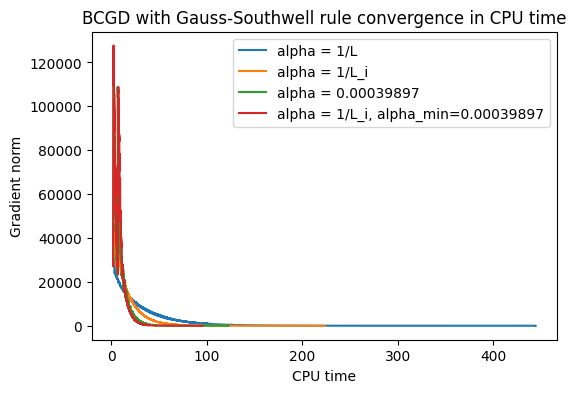

In [29]:
plt.figure(figsize=(6,4))
plt.plot(time_stat_GS4[1:], grad_GS4, label = "alpha = 1/L")
plt.plot(time_stat_GS[1:], grad_GS, label = "alpha = 1/L_i")
plt.plot(time_stat_GS3[1:], grad_GS3, label = "alpha = 0.00039897")
plt.plot(time_stat_GS2[1:], grad_GS2, label = "alpha = 1/L_i, alpha_min=0.00039897")
plt.title("BCGD with Gauss-Southwell rule convergence in CPU time")
plt.xlabel("CPU time")
plt.ylabel("Gradient norm")
plt.legend();

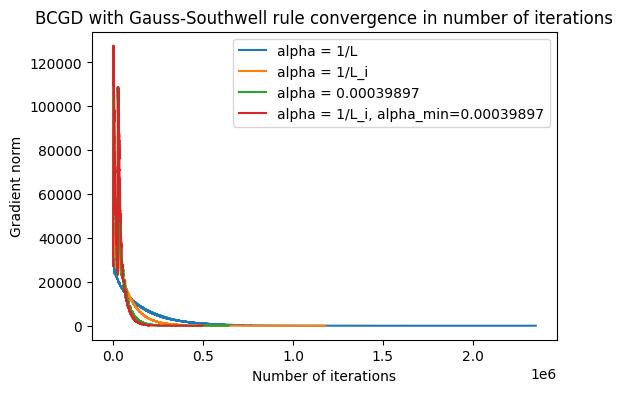

In [30]:
plt.figure(figsize=(6,4))
plt.plot(grad_GS4, label = "alpha = 1/L")
plt.plot(grad_GS, label = "alpha = 1/L_i")
plt.plot(grad_GS3, label = "alpha = 0.00039897")
plt.plot(grad_GS2, label = "alpha = 1/L_i, alpha_min=0.00039897")
plt.title("BCGD with Gauss-Southwell rule convergence in number of iterations")
plt.xlabel("Number of iterations")
plt.ylabel("Gradient norm")
plt.legend();

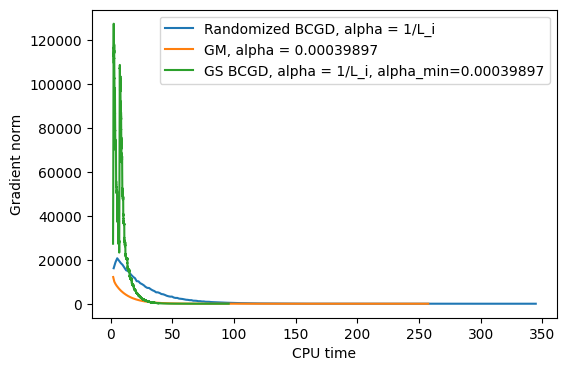

In [31]:
plt.figure(figsize=(6,4))
plt.plot(time_stat_RBc[1:], grad_RBc, label = "Randomized BCGD, alpha = 1/L_i")
plt.plot(time_stat_GM[1:], grad_GM, label = "GM, alpha = 0.00039897")
plt.plot(time_stat_GS2[1:], grad_GS2, label = "GS BCGD, alpha = 1/L_i, alpha_min=0.00039897")
#plt.title("Best algorithms convergence in CPU time")
plt.xlabel("CPU time")
plt.ylabel("Gradient norm")
plt.legend();

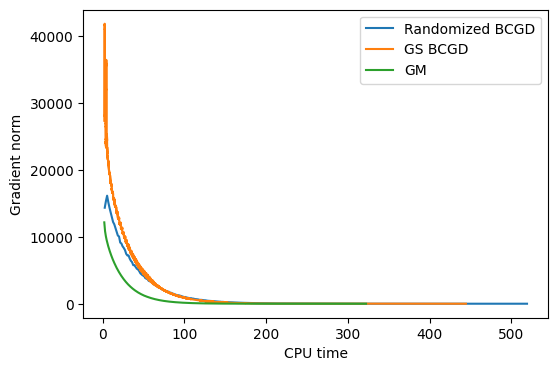

In [32]:
plt.figure(figsize=(6,4))
plt.plot(time_stat_RB3[1:], grad_RB3, label = "Randomized BCGD")
plt.plot(time_stat_GS4[1:], grad_GS4, label = "GS BCGD")
plt.plot(time_stat_GMc[1:], grad_GMc, label = "GM")
#plt.title("Algorithms convergence with alpha = 1/L")
plt.xlabel("CPU time")
plt.ylabel("Gradient norm")
plt.legend();

# Real Dataset

In [33]:
import time
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

def prepare_dataset(config):
    testsize = config['testsize']
    max_iter = config['maxiterations']
    eps = config['epsilon2']
    randomseed = config['randomseed']

    df = pd.read_csv ("/kaggle/input/citrus/citrus.csv")
    X = df[['diameter', 'weight', 'red', 'green', 'blue']].to_numpy()
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    scaler2 = MinMaxScaler(feature_range=(-100, 100))
    scaler2.fit(X)
    X = scaler2.transform(X)

    df.replace({'name': {'orange': -1, 'grapefruit': 1}}, inplace=True)
    y = df['name'].to_numpy()

    # first we shuffle and build the similarity matrix in order to separate later without shuffling and keep the form of the W matrix
    X, y = shuffle(X, y, random_state=1)
    W = rbf_kernel(X, gamma=1/100)
    X_l, X_u, y_l, y_u , W_l, W_u = train_test_split(X, y, W, test_size = testsize, shuffle=False)

    # delete the first 300 columns from the similarity matrix as we don't need them 
    n = len(y_l)
    W_l = W_l[:,n:]
    W_u = W_u[:,n:]
    return df, W_l, W_u, X_l, X_u, y_l, y_u,max_iter,eps,randomseed

In [34]:
df,W_l2, W_u2, X_l2, X_u2, y_l2, y_u2,max_iter2,eps2,randomseed2 = prepare_dataset(config)

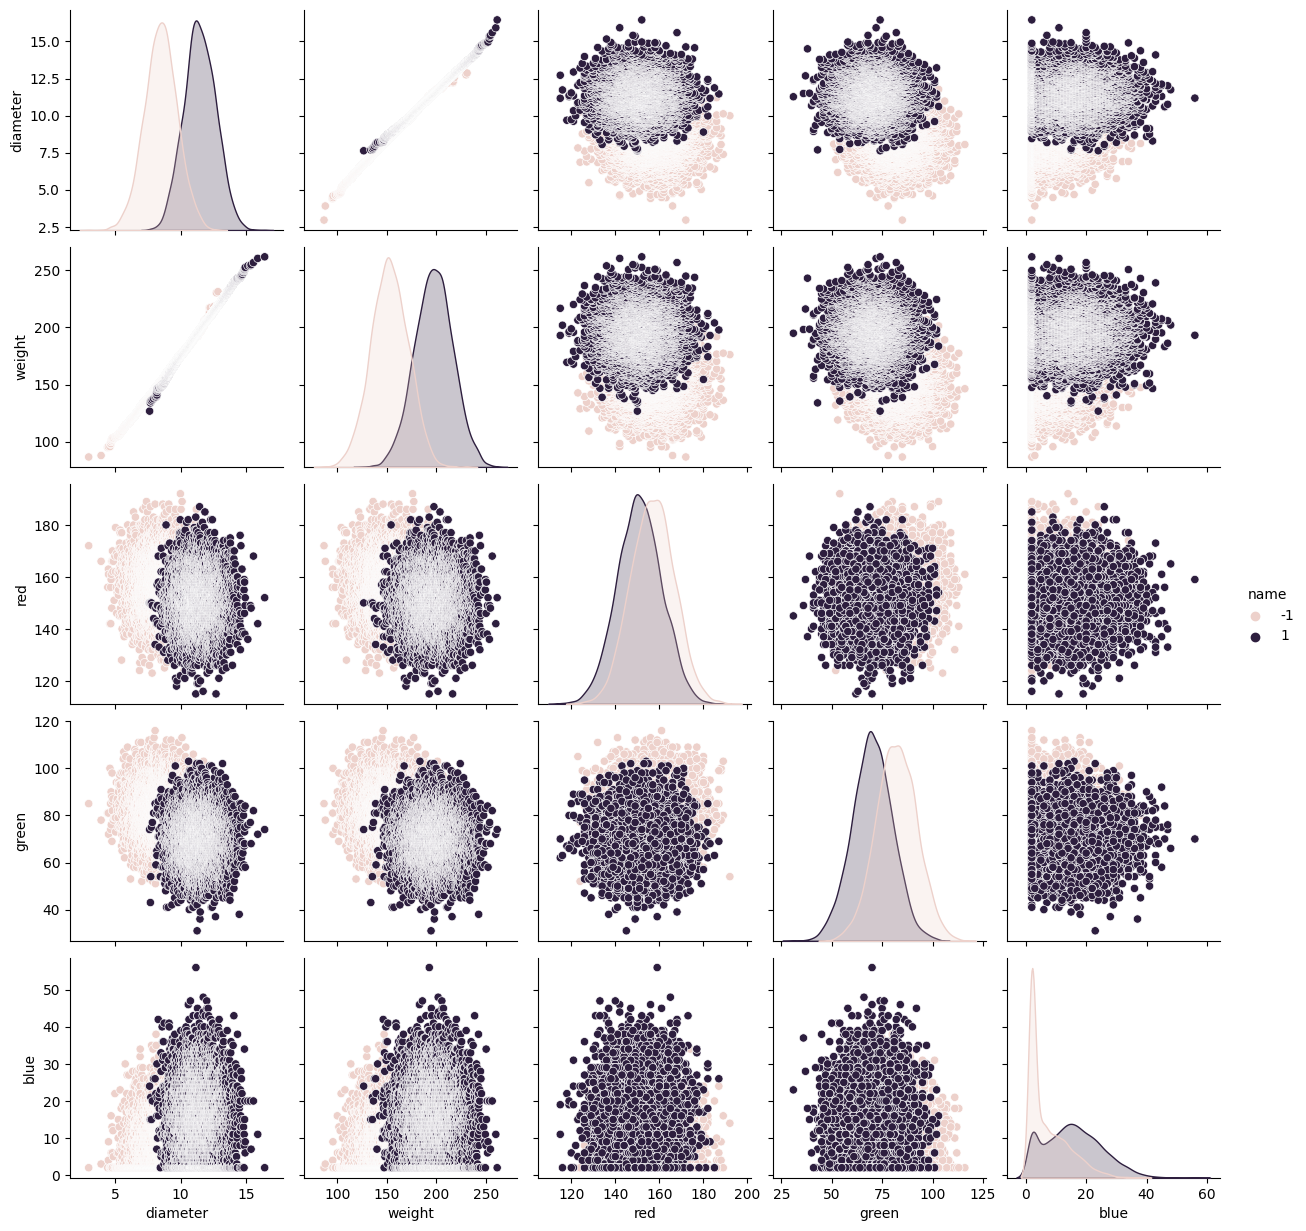

In [35]:
import seaborn as sns
_ = sns.pairplot(df,hue="name")

In [36]:
L2 = eigval_hessian(W_l2, W_u2)
stepsize2 = 1/L2
L2, stepsize2

(102.48934201830642, 0.009757112108509608)

In [37]:
n = len(W_u2)
hes = W_u2 * (-2)
diag_values = (W_l2.sum(axis=0) + W_u2.sum(axis=0)) * 2
np.fill_diagonal(hes, diag_values)
L_i2 = np.linalg.norm(hes, axis=1)
L_i2

array([13.96700941,  3.09683844,  6.51017422, ..., 18.05600917,
       13.13194884,  8.06706342])

In [38]:
y_pred_GM12, grad_GM12, time_stat_GM12, of_GM12 = GM(y_l2, W_l2, W_u2, stepsize2*2, max_iter, eps2, calc_of=False)

Initial loss: 2801.6675927750994
Iteration 1: gradient norm 0.9529842848532929
Iteration 2: gradient norm 0.6479863846509817
Iteration 3: gradient norm 0.5274683166575507
Iteration 4: gradient norm 0.45284641788249347
Iteration 5: gradient norm 0.39946087900805527
Iteration 6: gradient norm 0.35830973697089197
Iteration 7: gradient norm 0.32510598098465265
Iteration 8: gradient norm 0.29747495829335635
Iteration 9: gradient norm 0.27396443274809307
Iteration 10: gradient norm 0.2536217683411607
Iteration 11: gradient norm 0.23578844210011188
Iteration 12: gradient norm 0.21999031728547863
Iteration 13: gradient norm 0.20587468960430474
Iteration 14: gradient norm 0.1931720655164409
Iteration 15: gradient norm 0.18167186860958573
Iteration 16: gradient norm 0.17120640243006524
Iteration 17: gradient norm 0.16163992063446028
Iteration 18: gradient norm 0.15286097212760616
Iteration 19: gradient norm 0.14477691187288774
Iteration 20: gradient norm 0.13730988249247336
Iteration 21: gradien

In [39]:
%%time
y_pred_GM13, grad_GM13, time_stat_GM13, of_GM13 = GM(y_l2, W_l2, W_u2, stepsize2, max_iter, eps2, calc_of=False)

Initial loss: 2801.6675927750994
Iteration 1: gradient norm 0.9529842848532929
Iteration 2: gradient norm 0.7704874297694426
Iteration 3: gradient norm 0.6650341934043835
Iteration 4: gradient norm 0.5929491930690796
Iteration 5: gradient norm 0.5390000713189321
Iteration 6: gradient norm 0.4962936926433266
Iteration 7: gradient norm 0.4611761980656619
Iteration 8: gradient norm 0.43149693034802517
Iteration 9: gradient norm 0.40589207957927054
Iteration 10: gradient norm 0.3834468150742539
Iteration 11: gradient norm 0.363519756199058
Iteration 12: gradient norm 0.34564486868852257
Iteration 13: gradient norm 0.3294733813775879
Iteration 14: gradient norm 0.3147377402482925
Iteration 15: gradient norm 0.3012283388647468
Iteration 16: gradient norm 0.28877798255210807
Iteration 17: gradient norm 0.27725120982104356
Iteration 18: gradient norm 0.2665367637059111
Iteration 19: gradient norm 0.25654216405715363
Iteration 20: gradient norm 0.24718971644540366
Iteration 21: gradient norm 0.

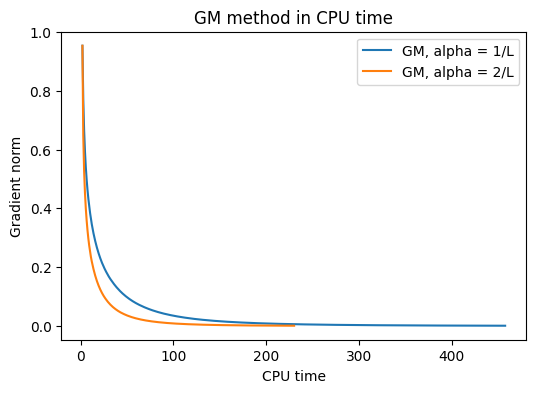

In [40]:
plt.figure(figsize=(6,4))
plt.plot(time_stat_GM13[1:], grad_GM13, label = "GM, alpha = 1/L")
plt.plot(time_stat_GM12[1:], grad_GM12, label = "GM, alpha = 2/L")
plt.title("GM method in CPU time")
plt.xlabel("CPU time")
plt.ylabel("Gradient norm")
plt.legend();

In [41]:
%%time
y_pred_RB11, grad_RB11, time_stat_RB11, of_RB11 = rand_BCGD(y_l2, W_l2, W_u2, np.repeat(51, len(W_u)), max_iter, eps2, random_seed=random_seed)

Initial loss: 2801.6675927750994
Cycle 1: gradient norm 1.2317306780166726
Cycle 2: gradient norm 1.1807437300155825
Cycle 3: gradient norm 1.259533624544431
Cycle 4: gradient norm 1.0026351229186792
Cycle 5: gradient norm 0.8650952499180452
Cycle 6: gradient norm 0.8456024189046023
Cycle 7: gradient norm 0.7825755335222793
Cycle 8: gradient norm 0.6219269482796052
Cycle 9: gradient norm 0.6625369117770893
Cycle 10: gradient norm 0.5955845611090834
Cycle 11: gradient norm 0.47539879935528334
Cycle 12: gradient norm 0.42026460496683593
Cycle 13: gradient norm 0.4127056178875857
Cycle 14: gradient norm 0.3566401938435217
Cycle 15: gradient norm 0.3800240092235925
Cycle 16: gradient norm 0.36929427513946633
Cycle 17: gradient norm 0.3196385354545192
Cycle 18: gradient norm 0.2921973220712746
Cycle 19: gradient norm 0.2648432671371537
Cycle 20: gradient norm 0.2756066377127643
Cycle 21: gradient norm 0.23817473906428963
Cycle 22: gradient norm 0.264205840834432
Cycle 23: gradient norm 0.21

In [42]:
%%time
y_pred_RB12, grad_RB12, time_stat_RB12, of_RB12 = rand_BCGD(y_l2, W_l2, W_u2, L_i2, max_iter, eps2, random_seed=random_seed)

Initial loss: 2801.6675927750994
Cycle 1: gradient norm 1.1039239990010115
Cycle 2: gradient norm 0.9866357259043677
Cycle 3: gradient norm 1.050550202983112
Cycle 4: gradient norm 0.8634964364942401
Cycle 5: gradient norm 0.7826479937463173
Cycle 6: gradient norm 0.7300176167245648
Cycle 7: gradient norm 0.6770998969653202
Cycle 8: gradient norm 0.5871862997041504
Cycle 9: gradient norm 0.6747592979136299
Cycle 10: gradient norm 0.5110677114970106
Cycle 11: gradient norm 0.4632699198309224
Cycle 12: gradient norm 0.4112353041585876
Cycle 13: gradient norm 0.42157871259312013
Cycle 14: gradient norm 0.37341531204718026
Cycle 15: gradient norm 0.3527731937910999
Cycle 16: gradient norm 0.345569041455946
Cycle 17: gradient norm 0.3220569758632556
Cycle 18: gradient norm 0.28041690011164133
Cycle 19: gradient norm 0.26547799659059157
Cycle 20: gradient norm 0.2421666250483449
Cycle 21: gradient norm 0.20768287780172473
Cycle 22: gradient norm 0.20378207434669757
Cycle 23: gradient norm 0.

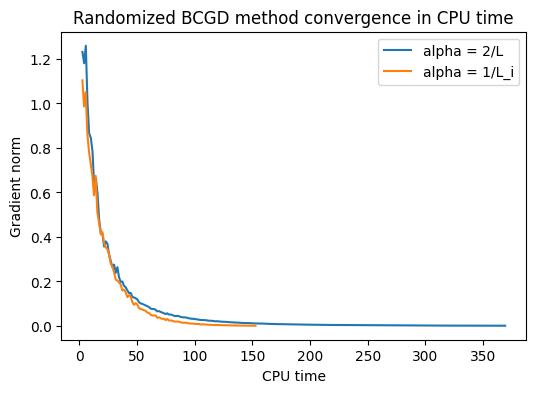

In [43]:
plt.figure(figsize=(6,4))
plt.plot(time_stat_RB11[1:], grad_RB11, label = "alpha = 2/L")
plt.plot(time_stat_RB12[1:], grad_RB12, label = "alpha = 1/L_i")
plt.title("Randomized BCGD method convergence in CPU time")
plt.xlabel("CPU time")
plt.ylabel("Gradient norm")
plt.legend();

In [44]:
%%time
y_pred_GS12, grad_GS12, time_stat_GS12, of_GS12 = GS_BCGD(y_l2, W_l2, W_u2, np.repeat(51, len(W_u)), max_iter, eps2)

Initial loss: 2801.6675927750994
Cycle 1: gradient norm 2.1251715575247236
Cycle 2: gradient norm 1.0760253415270218
Cycle 3: gradient norm 0.7597702774022748
Cycle 4: gradient norm 0.5724781876168854
Cycle 5: gradient norm 0.4568088144515202
Cycle 6: gradient norm 0.3814125870497683
Cycle 7: gradient norm 0.3227024296258051
Cycle 8: gradient norm 0.2885181721291996
Cycle 9: gradient norm 0.24804751010028486
Cycle 10: gradient norm 0.21896534567505913
Cycle 11: gradient norm 0.19503762197657848
Cycle 12: gradient norm 0.17526414510307034
Cycle 13: gradient norm 0.16036911204872456
Cycle 14: gradient norm 0.1473665650929231
Cycle 15: gradient norm 0.13583743388353847
Cycle 16: gradient norm 0.12816059480704597
Cycle 17: gradient norm 0.11776611537146946
Cycle 18: gradient norm 0.1079300880267038
Cycle 19: gradient norm 0.10539835638166382
Cycle 20: gradient norm 0.10033787370831636
Cycle 21: gradient norm 0.09009082030016101
Cycle 22: gradient norm 0.08391918972590219
Cycle 23: gradient

In [45]:
%%time
y_pred_GS11, grad_GS11, time_stat_GS11, of_GS11 = GS_BCGD(y_l2, W_l2, W_u2, L_i2, max_iter, eps2)

Initial loss: 2801.6675927750994
Cycle 1: gradient norm 2.5424494159194935
Cycle 2: gradient norm 1.2966225490351113
Cycle 3: gradient norm 0.8007867591734525
Cycle 4: gradient norm 0.5656578119790239
Cycle 5: gradient norm 0.42028930111656
Cycle 6: gradient norm 0.31142888374443456
Cycle 7: gradient norm 0.24282875288913452
Cycle 8: gradient norm 0.19246114960954372
Cycle 9: gradient norm 0.1649819185116378
Cycle 10: gradient norm 0.1362618212408566
Cycle 11: gradient norm 0.10788685826224398
Cycle 12: gradient norm 0.09436509121207913
Cycle 13: gradient norm 0.08409450487801474
Cycle 14: gradient norm 0.06526536755859894
Cycle 15: gradient norm 0.055417716748162704
Cycle 16: gradient norm 0.05173751318720699
Cycle 17: gradient norm 0.04037180513143872
Cycle 18: gradient norm 0.03545111572516679
Cycle 19: gradient norm 0.04063167168160131
Cycle 20: gradient norm 0.025807977821769704
Cycle 21: gradient norm 0.024923069914138795
Cycle 22: gradient norm 0.019537018583427792
Cycle 23: gra

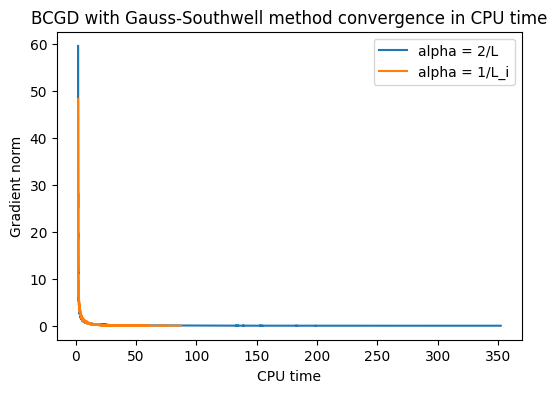

In [46]:
plt.figure(figsize=(6,4))
plt.plot(time_stat_GS12[1:], grad_GS12, label = "alpha = 2/L")
plt.plot(time_stat_GS11[1:], grad_GS11, label = "alpha = 1/L_i")
plt.title("BCGD with Gauss-Southwell method convergence in CPU time")
plt.xlabel("CPU time")
plt.ylabel("Gradient norm")
plt.legend();

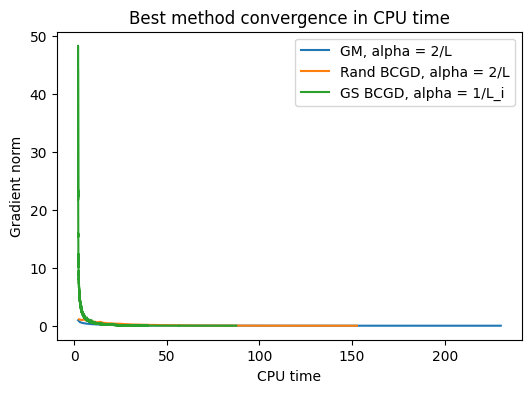

In [47]:
plt.figure(figsize=(6,4))
plt.plot(time_stat_GM12[1:], grad_GM12, label = "GM, alpha = 2/L")
plt.plot(time_stat_RB12[1:], grad_RB12, label = "Rand BCGD, alpha = 2/L")
plt.plot(time_stat_GS11[1:], grad_GS11, label = "GS BCGD, alpha = 1/L_i")
plt.title("Best method convergence in CPU time")
plt.xlabel("CPU time")
plt.ylabel("Gradient norm")
plt.legend();

In [48]:
y_norm = [1 if i > 0 else -1 for i in y_pred_GM12]
y_norm = np.array(y_norm)
ac_GM = np.sum(y_norm == y_u2) / len(y_u2)

y_norm = [1 if i > 0 else -1 for i in y_pred_RB12]
y_norm = np.array(y_norm)
ac_RB = np.sum(y_norm == y_u2) / len(y_u2)

y_norm = [1 if i > 0 else -1 for i in y_pred_GS11]
y_norm = np.array(y_norm)
ac_GS = np.sum(y_norm == y_u2) / len(y_u2)

ac_GM, ac_RB, ac_GS

(0.9209278350515464, 0.921958762886598, 0.9105154639175258)